In [639]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [640]:
%autoreload 2

import numpy as np

import helper as h

import l2distance

import matplotlib.pyplot as plt

from visclassifier import visclassifier

Recall that the we can express the solution as a linear combination of the training examples $ \{\phi(\mathbf{x}_1), \cdots, \phi(\mathbf{x}_n) \}$:
$$
    \begin{aligned}
    \mathbf{w} = \sum_{j = 1}^n \alpha_j y_j \phi(\mathbf{x}_j)
    \end{aligned}
$$

To simplify, we define $\beta_j = \alpha_j y_j$ and we can express the solution as: 
$$
    \begin{aligned}
    \mathbf{w} = \sum_{j = 1}^n \beta_j \phi(\mathbf{x}_j)
    \end{aligned}
$$

If we substitute the formulation above into our unconstrained regularized squared hinge loss, 
$$
    \begin{aligned}
    \min_{\mathbf{w},b}\underbrace{\mathbf{w}^T\mathbf{w}}_{l_{2} \text{ regularizer} } +  C\  \sum_{i=1}^{n}\underbrace{\max\left [ 1-y_{i}(\mathbf{w}^T \mathbf{x}_i+b),0 \right ] ^2}_{ \text{squared hinge loss} }
    \end{aligned}
$$

we obtain: 

$$
\begin{aligned}
       \underbrace{\sum_{i = 1} ^n \sum_{j = 1}^n \beta_i  \beta_j \phi(\mathbf{x} _i)^T \phi(\mathbf{x}_j)}_{l_{2} \text{ regularizer}} +  C\  \sum_{i=1}^{n}\underbrace{\max\left [ 1-y_{i}(\sum_{j = 1}^n \beta_j \phi(\mathbf{x}_j)^T \phi(\mathbf{x}_i)+b),0 \right ] ^ 2}_{\text{squared hinge loss}}     
\end{aligned}
$$
Now, if we replace all the $\phi(\mathbf{x} _i)^T \phi(\mathbf{x}_j)$ with $k(\mathbf{x}_i, \mathbf{x}_j)$, we obtained the "kernelized" hinge loss. 

$$
\begin{aligned}
      \min_{\beta_1,\cdots,\beta_n, b} \underbrace{\sum_{i = 1} ^n \sum_{j = 1}^n \beta_i \beta_j k(\mathbf{x} _i, \mathbf{x}_j)}_{l_{2} \text{ regularizer}} +  C\  \sum_{i=1}^{n}\underbrace{\max\left [ 1-y_{i}(\sum_{j = 1}^n \beta_j k(\mathbf{x}_j, \mathbf{x}_i)+b),0 \right ] ^ 2}_{\text{squared hinge loss}}
\end{aligned}
$$

The expression above seems a little bit unweildy, so we are going to simplify the expression again. First, we will simplfy the $l_{2}$-regularizer. Define $\mathbf{\beta} = [\beta_1, \cdots, \beta_n]^T$ and $K_{train}$ to the kernel matrix calculated on the training set, namely, the (i, j)-th entry of $K_{train}$ is $k(\mathbf{x} _i, \mathbf{x}_j)$. It is easy to verify that the $l_{2}$-regularizer can be expressed as the quadratic form  

$$
    \sum_{i = 1} ^n \sum_{j = 1}^n \beta_i \beta_j k(\mathbf{x} _i, \mathbf{x}_j) = \mathbf{\beta}^T K_{train} \mathbf{\beta}
$$

Now, let's simplify the the squared hinge-loss. To start, we define $K_{train}[i]$ as the i-th row of $k_{train}$ expressed as a column vector. Now, the summation term within the hinge loss can be expressed as: 

$$
    \sum_{ j = 1}^n \beta_j k(\mathbf{x}_j, \mathbf{x}_i) = \mathbf{\beta}^T K_{train}[i]
$$

Combining the two simplifications we have, we arrive at: 
$$
\begin{aligned}
      \min_{\mathbf{\beta}, b} \underbrace{\mathbf{\beta}^T k_{train} \mathbf{\beta}}_{l_{2}  \text{ regularizer}} +  C\  \sum_{i=1}^{n}\underbrace{\max\left [ 1-y_{i}(\mathbf{\beta}^T K_{train}[i]+b),0 \right ] ^ 2}_{\text{squared hinge loss}}
\end{aligned}
$$
Note that the loss function we have above is very similar to the vanilla linear SVM, the differences are: 

1. Instead of $\mathbf{w}$, we have $\mathbf{\beta}$
2. The $l_{2}$-regularizer $\mathbf{w}^T \mathbf{w} = \mathbf{w}^T I \mathbf{w}$ is changed to $\mathbf{\beta}^T k_{train} \mathbf{\beta}$ to account for using $\mathbf{\beta}$ instead of $\mathbf{w}$
3. The inner product $\mathbf{w}^T \mathbf{x}_j$ in the hinge loss is changed to $\mathbf{\beta}^T K_{train}[j]$

This assignment is very similar to the linear SVM assignment. You will implement the <code>loss</code> and <code>grad</code> as before and you will also implement <code>computeK</code> that efficiently computes the kernel matrix. Before we start, let's generate some data and visualize the training set

<IPython.core.display.Javascript object>


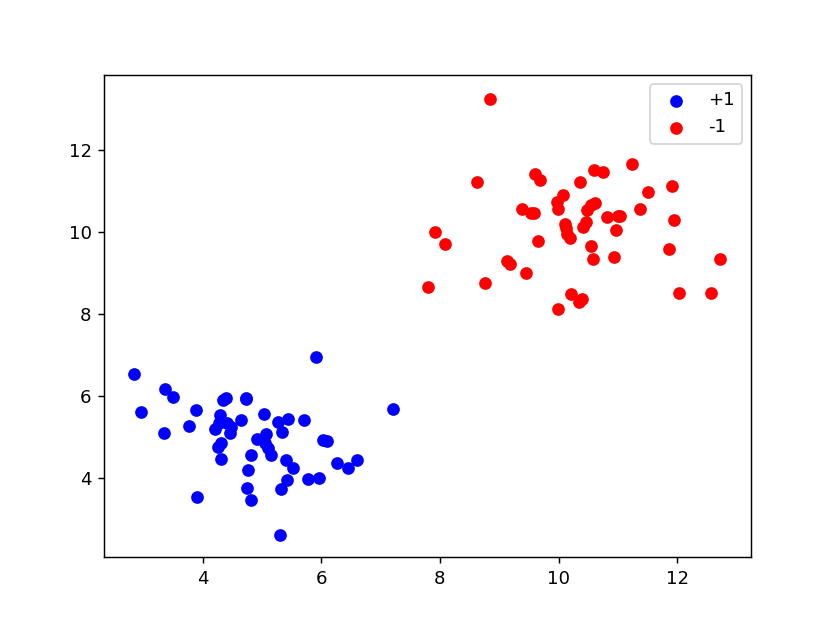

In [641]:
%matplotlib notebook
# xTr,yTr,xTe,yTe = h.spiraldata()
xTr,yTr = h.generate_data()
h.visualize_2D(xTr, yTr)

In this assignment, you need to implement three functions <code>computeK</code> that computes the kernel function efficiently, <code>loss</code> that calculates the unconstrained kernelized hinge loss and <code>grad</code> that calculates the gradient of the loss with respect to $\alpha_1, \cdots , \alpha_n, b$

In <code>computeK</code>, you are going to calcuate the values of different kernel functions. Note that when calculating the rbf kernel, you can use the <code>h.l2distance(X, Z)</code> functions to calculate the pairwise l2 distance efficiently.

In [642]:
def computeK(kerneltype, X, Z, kpar=0):
    """
    function K = computeK(kernel_type, X, Z)
    computes a matrix K such that Kij=k(x,z);
    for three different function linear, rbf or polynomial.
    
    Input:
    kerneltype: either 'linear','polynomial','rbf'
    X: n input vectors of dimension d (nxd);
    Z: m input vectors of dimension d (mxd);
    kpar: kernel parameter (inverse kernel width gamma in case of RBF, degree in case of polynomial)
    
    OUTPUT:
    K : nxm kernel matrix
    """
    assert kerneltype in ["linear","polynomial","poly","rbf"], "Kernel type %s not known." % kerneltype
    assert X.shape[1] == Z.shape[1], "Input dimensions do not match"
    
    ## Solution Start
    if kerneltype == "linear":
        K = X.dot(Z.T)
    elif kerneltype == "polynomial":
        K = np.power((X.dot(Z.T) + 1), kpar)
    elif kerneltype =='rbf':
        K = np.exp(-kpar*np.square(h.l2distance(X,Z)))
    else:
        raise ValueError('Invalid Kernel Type!')
    ## Solution End
    return K

Now, you are going to implement the <code>loss</code>. Note that the function signature of this function is slightly different from the previous assignment. Previously, we can pass in $\mathbf{w}$ to calculate the loss values. However, in the kernelized version of the loss, $\mathbf{w}$ is calculated as the linear combination of the training examples, so we need to pass the training set to the function. 

In [643]:
def loss(beta, b, xTr, yTr, xTe, yTe, C, kerneltype, kpar=1):
    """
    INPUT:
    beta : n dimensional vector that stores the linear combination coefficient
    xTr   : nxd dimensional matrix (training set, each row is an input vector)
    yTr   : n   dimensional vector (training label, each entry is a label)
    b     : scalar (bias)
    xTe   : mxd dimensional matrix (test set, each row is an input vector)
    yTe   : m dimensional vector (test label, each entry is a label)
    C     : scalar (constant that controls the tradeoff between l2-regularizer and hinge-loss)
    kerneltype: either 'linear','polynomial','rbf'
    kpar  : kernel parameter (inverse kernel width gamma in case of RBF, degree in case of polynomial)
    
    OUTPUTS:
    loss     : the total loss obtained with (alpha, xTr, yTr, b) on xTe and yTe (scalar)
    """
    
    loss = 0.0
    
    # compute the kernel values between xTr and xTr 
    kernel_train = computeK(kerneltype, xTr, xTr, kpar)
    # compute the kernel values between xTe and xTr
    kernel_test = computeK(kerneltype, xTe, xTr, kpar)
    
    ### BEGIN SOLUTION
    prediction = kernel_test @ beta  + b
    margin = yTe * prediction
    
#     loss = beta @ kernel_train @ beta
    loss = beta @ kernel_train @ beta 
    loss += C*(np.sum(np.maximum(1 - margin, 0) ** 2))
    ### END SOLUTION
    
#     print('l2', interm @ kernel_train @ interm)
#     print('hinge loss', (np.sum(np.maximum(1 - margin, 0) ** 2)))
    return loss

In [644]:
def grad(beta, b, xTr, yTr, xTe, yTe, C, kerneltype, kpar=1):
    """
    INPUT:
    beta : n dimensional vector that stores the linear combination coefficient
    xTr   : nxd dimensional matrix (training set, each row is an input vector)
    yTr   : n   dimensional vector (training label, each entry is a label)
    b     : scalar (bias)
    xTe   : mxd dimensional matrix (test set, each row is an input vector)
    yTe   : m dimensional vector (test label, each entry is a label)
    C     : scalar (constant that controls the tradeoff between l2-regularizer and hinge-loss)
    kerneltype: either 'linear','polynomial','rbf'
    kpar  : kernel parameter (inverse kernel width gamma in case of RBF, degree in case of polynomial)
    
    
    OUTPUTS:
    alpha_grad :  n dimensional vector (the gradient of the hinge loss with respect to the alphas)
    bgrad :  constant (the gradient of he hinge loss with respect to the bias, b)
    """
    
    n, d = xTr.shape
    
    alpha_grad = np.zeros(n)
    bgrad = np.zeros(1)
    
    # compute the kernel values between xTr and xTr 
    kernel_train = computeK(kerneltype, xTr, xTr, kpar)
    # compute the kernel values between xTe and xTr
    kernel_test = computeK(kerneltype, xTe, xTr, kpar)
    
    ### BEGIN SOLUTION
    prediction = kernel_test @ beta + b
    margin = yTe * prediction
    
    hinge = np.maximum(1 - margin, 0)
    indicator = ((1 - margin) > 0).astype(int)
    
    alpha_grad = 2 * (kernel_train @ (beta))
    alpha_grad += C * np.sum((2 * hinge * indicator * -yTe).reshape(-1, 1) * kernel_test, axis=0)
    bgrad = 0
    
#     print("margin", margin)
#     print("hinge", hinge)
#     print("indicator", indicator)
    bgrad += C * np.sum(2 * hinge * indicator * -yTe, axis=0)
    
    ### END SOLUTION
    return alpha_grad, bgrad

In [645]:
from scipy.optimize import check_grad, approx_fprime

In [646]:
def loss_lambda(X):
    return loss(X[:-1], X[-1], xTr, yTr, xTr, yTr, 1, 'linear', 1)

def grad_lambda(X):
    return np.append(*grad(X[:-1], X[-1], xTr, yTr, xTr, yTr, 1, 'linear', 1))

beta = np.random.rand(xTr.shape[0])
b = np.random.rand(1)

init = np.append(beta, np.array(b))
init2 = np.append(beta, np.array(b) + np.finfo(float).eps)
init3 = np.append(beta + np.finfo(float).eps, np.array(b))

In [647]:
loss_lambda(init)

2963424116.7561316

In [648]:
loss_lambda(init2)

2963424116.7561316

In [649]:
loss_lambda(init3)

2963424116.756134

In [650]:
(loss_lambda(init) - loss_lambda(init2)) / np.finfo(float).eps

0.0

In [651]:
grad_lambda(init)[-1]

767813.2831513156

In [652]:
check_grad(loss_lambda, grad_lambda, x0=init)

242.2964481034369

In [653]:
grad_lambda(init)[-10:]

array([1.64870700e+08, 1.74838880e+08, 1.76971543e+08, 1.55970782e+08,
       1.52944172e+08, 1.57347985e+08, 1.39928346e+08, 1.65160386e+08,
       1.59053112e+08, 7.67813283e+05])

In [654]:
approx_fprime(init, loss_lambda, epsilon=np.sqrt(np.finfo(float).eps))[-10:]

array([1.64870752e+08, 1.74838880e+08, 1.76971584e+08, 1.55970816e+08,
       1.52944192e+08, 1.57348000e+08, 1.39928352e+08, 1.65160416e+08,
       1.59053088e+08, 7.67840000e+05])

In [655]:
np.abs((grad_lambda(init) - approx_fprime(init, loss_lambda, epsilon=np.sqrt(np.finfo(float).eps  / 10))))[-10:]

array([ 34.22473207,  61.45831594,  39.05288881,  38.08311674,
        70.1310499 ,  70.01787138, 163.15457788,  63.86505973,
        42.9715482 ,  62.863705  ])

In [656]:
np.amax((grad_lambda(init) - approx_fprime(init, loss_lambda, epsilon=np.sqrt(np.finfo(float).eps))))

42.85165533423424

In [657]:
# alpha_sol, bias_sol, final_loss = h.minimize(objective=loss, grad=grad, xTr=xTr, yTr=yTr, C=1000, kerneltype='linear', kpar=1)
alpha_sol, bias_sol, final_loss = h.minimize(objective=loss, grad=grad, xTr=xTr, yTr=yTr, C=100, kerneltype='linear', kpar=1)
print('The Final Loss of your model is: {:0.4f}'.format(final_loss))

     fun: 0.6213622064841549
     jac: array([-2.93917224, -3.00573863, -2.91024673, -3.07158374, -3.37841505,
       -2.6431612 , -3.08600365, -2.92064398, -2.96706585, -2.9793885 ,
       -2.93919201, -2.87525901, -2.79423567, -2.73273328, -3.32338063,
       -2.77059444, -2.84954392, -2.57543842, -2.71244889, -3.16762441,
       -3.26096764, -3.2351172 , -3.00716966, -3.21551458, -3.33147408,
       -2.36731592, -3.23142116, -2.75271483, -2.95118006, -3.17386947,
       -2.66933147, -2.9476658 , -2.9199323 , -2.82860296, -2.94754315,
       -2.98664335, -3.31429684, -2.50080636, -2.98256461, -3.89564498,
       -3.00439564, -2.593198  , -3.14416596, -3.26734137, -2.99373522,
       -3.92837108, -3.20850784, -2.26023699, -3.30572641, -2.92765051,
       -6.04021934, -6.47996371, -6.73437836, -5.48086863, -6.14598763,
       -5.60791022, -6.15453139, -6.50025772, -6.39560618, -6.65859425,
       -6.34308126, -5.32106378, -6.0892619 , -5.65854358, -6.37579148,
       -6.28694105, -5.63

In [658]:
print(computeK('linear', xTr, xTr, 1).transpose().dot(alpha_sol * yTr) + bias_sol)
predsTr=svmclassify(xTr)
trainingerr=np.mean(np.sign(predsTr)!=yTr)
print("Training error: %2.4f" % trainingerr)

# predsTe=svmclassify(xTe)
# testingerr=np.mean(np.sign(predsTe)!=yTe)
# print("Testing error: %2.4f" % testingerr)

[11.42195366 11.49222073 11.33274367 11.57596735 11.94121665 11.0573269
 11.60872846 11.41050378 11.45964398 11.5108067  11.48391429 11.35188791
 11.27149358 11.24877404 11.92021772 11.22418173 11.35009073 11.06032096
 11.20445687 11.66618958 11.77787186 11.77338261 11.52492791 11.80091202
 11.90818562 10.86506685 11.75924575 11.22576185 11.48580036 11.71149387
 11.14089017 11.46707153 11.36967942 11.35317576 11.39339387 11.50608572
 11.88692293 10.98489598 11.47290108 12.54491225 11.51656844 11.02101994
 11.63990638 11.78434621 11.54823027 12.52590961 11.7863556  10.69556096
 11.85391642 11.39378831 14.93130611 15.39342719 15.65913969 14.23546992
 15.0228292  14.41855207 15.06558026 15.43160537 15.26667577 15.66734003
 15.33027337 14.10250461 14.9665367  14.51561214 15.29851774 15.18475071
 14.49502453 15.60532354 14.98638455 15.12554703 14.96294194 15.64144769
 15.12995701 15.42571084 15.71241222 14.42453839 15.48111488 15.18428644
 14.40286695 15.97796246 15.15194637 15.04989281 13.

In [659]:
# Build classifier
# bias_sol = b_torch.data.numpy()
# alpha_sol = alpha_torch.data.numpy()

# interm = alpha_sol*yTr
svmclassify = lambda x: np.sign(computeK('linear', x, xTr, 1).dot(alpha_sol) + bias_sol)

# interm = out[0]*yTr
# svmclassify = lambda x: np.sign(computeK('linear', xTr, x, 1).transpose().dot(interm) + out[1])

In [660]:
# reconstruct the w
w = xTr.T @ alpha_sol

In [661]:
np.amin(xTr[yTr == 1] @ w + bias_sol)

0.9969810468636684

In [666]:
np.argmin(yTr * (xTr @ w + bias_sol))

82

In [662]:
np.amin(-(xTr[yTr == -1] @ w + bias_sol))

0.9968874392122817

In [663]:
print(alpha_sol)

[-0.00050925 -0.0005339  -0.00072053 -0.00050442 -0.00046159 -0.00059694
 -0.0004434  -0.00047171 -0.00048838 -0.00034859 -0.00027491 -0.00049541
 -0.00044597 -0.00026352 -0.00030086 -0.0005218  -0.00038998 -0.00029005
 -0.00034266 -0.00058221 -0.00056703 -0.0004712  -0.0004164  -0.00028149
 -0.0003817  -0.00012049 -0.00050856 -0.00043779 -0.00032009 -0.00043805
 -0.00039499 -0.00037561 -0.00062306 -0.00028691 -0.00065383 -0.00039811
 -0.00038718 -0.00024971 -0.00050586 -0.00043484 -0.00043592 -0.00051625
 -0.00057927 -0.00057035 -0.00026961 -0.00064956 -0.00030599 -0.00029449
 -0.00047466 -0.00056553 -0.00076543 -0.00093616 -0.00104118 -0.00095697
 -0.00088076 -0.00081872 -0.0007563  -0.00088028 -0.00104757 -0.00067941
 -0.00057771 -0.00076261 -0.00084617 -0.00067247 -0.00084062 -0.00088329
 -0.00064003 -0.00088802 -0.00086149 -0.0008699  -0.0009499  -0.00133401
 -0.00094373 -0.00088281 -0.00082938 -0.00076637 -0.00101318 -0.0009662
 -0.00080533 -0.00093761 -0.00060065 -0.00089349 -0.

In [669]:
print(np.amax(alpha_sol))

-0.00012049119866371339


In [667]:
print(alpha_sol[82])

-0.0007888115500547793


In [668]:
xTr[82]

array([7.80532679, 8.65079836])

<IPython.core.display.Javascript object>


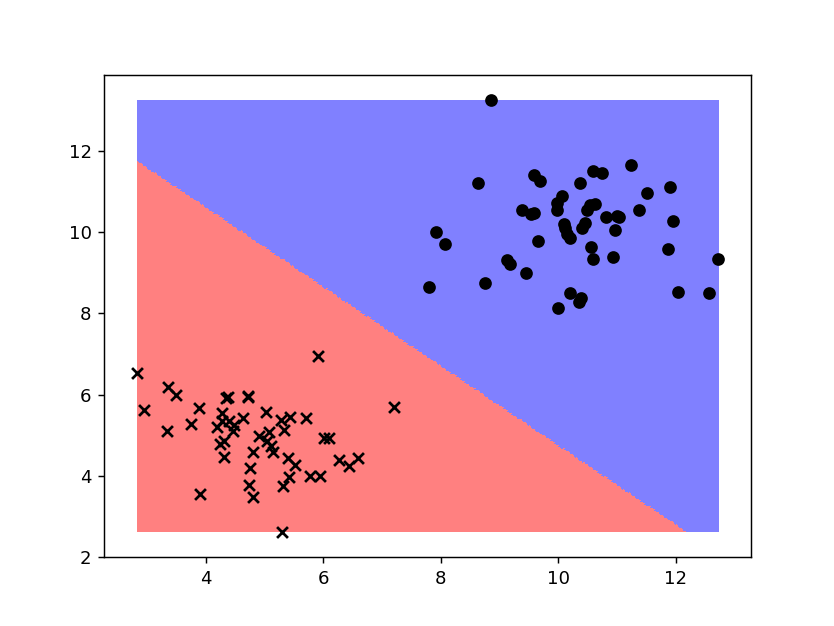

In [664]:
from visclassifier import visclassifier
visclassifier(svmclassify, xTr, yTr)

In [351]:
def loss_slow(beta, b, xTr, yTr, xTe, yTe, C, kerneltype, kpar=1):
    """
    INPUT:
    alpha : n dimensional vector that stores the linear combination coefficient
    xTr   : nxd dimensional matrix (training set, each row is an input vector)
    yTr   : n   dimensional vector (training label, each entry is a label)
    b     : scalar (bias)
    xTe   : mxd dimensional matrix (test set, each row is an input vector)
    yTe   : m dimensional vector (test label, each entry is a label)
    C     : scalar (constant that controls the tradeoff between l2-regularizer and hinge-loss)
    kerneltype: either 'linear','polynomial','rbf'
    kpar  : kernel parameter (inverse kernel width gamma in case of RBF, degree in case of polynomial)
    
    OUTPUTS:
    loss     : the total loss obtained with (alpha, xTr, yTr, b) on xTe and yTe (scalar)
    """
    
    loss = 0.0
    n, d = xTr.shape
    m, d = xTe.shape
    # compute the kernel values between xTr and xTr 
    kernel_train = computeK(kerneltype, xTr, xTr, kpar)
    # compute the kernel values between xTr and xTe
    kernel_test = computeK(kerneltype, xTr, xTe, kpar)
    
    l2 = 0.0
    for i in range(n):
        for j in range(n):
            l2 += beta[i] * beta[j] * kernel_train[i, j]
            
    hinge_loss =  []
    for j in range(m):
        hinge_loss.append(np.maximum(1 - yTe[j] * (np.sum([beta[i] * kernel_test[i, j] for i in range(n)]) + b), 0) ** 2)
    ### END SOLUTION
    
#     print("l2", l2)
#     print('hinge loss', hinge_loss)
    loss = l2 + C*np.sum(hinge_loss)
    return loss

In [352]:
import torch

In [353]:
def loss_torch(beta, b, xTr, yTr, xTe, yTe, C, kerneltype, kpar=1):
    m, d = xTe.shape
    loss = 0.0
    # compute the kernel values between xTr and xTr 
    kernel_train = torch.from_numpy(computeK(kerneltype, xTr, xTr, kpar))
    # compute the kernel values between xTr and xTe
    kernel_test = torch.from_numpy(computeK(kerneltype, xTr, xTe, kpar))
    
    ### BEGIN SOLUTION
    prediction = torch.matmul(beta ,  kernel_test)  + b
    margin = torch.from_numpy(yTe).double() * prediction
    loss = torch.matmul(beta, torch.matmul(kernel_train,  beta))  +  C*torch.sum((torch.max(1 - margin, torch.zeros(m).double()) ** 2), dim=0)
    return loss

In [354]:
beta_torch = torch.from_numpy(beta)
b_torch = torch.from_numpy(beta)

beta_torch.requires_grad_(True)
b_torch.requires_grad_(True)

loss_torch(beta_torch, b_torch, xTr, yTr, xTr, yTr, 1000, 'rbf', kpar=1)

tensor(2475017.1879, dtype=torch.float64, grad_fn=<AddBackward0>)

In [355]:
C = 10
alpha = np.zeros(xTr.shape[0])
b = np.zeros(1)
print(loss(alpha, b, xTr, yTr, xTr, yTr, C, 'linear', kpar=1))
print(loss_slow(alpha, b, xTr, yTr, xTr, yTr, C, 'linear', kpar=1))
grad(alpha, b, xTr, yTr, xTr, yTr, C, 'linear', kpar=1)

1000.0
1000.0


(array([ 47192.58264747,  56013.70743973,  40911.06993945,  46571.29331826,
         41853.61540509,  52047.89410152,  48970.10125197,  52359.77538126,
         56316.46206537,  48998.82769315,  37163.59729995,  58558.76106507,
         41463.44569761,  58302.33106913,  57374.09597084,  36753.40973266,
         56500.56770138,  48967.28600403,  49247.81246571,  53423.4118416 ,
         45890.88461392,  58351.63109874,  46258.01743473,  46459.14368997,
         44752.53699565,  32204.61833181,  49748.04354083,  55009.45444359,
         65215.75051281,  47920.10401557,  43835.62757509,  47541.27858576,
         53065.32674048,  36385.4327395 ,  47190.92043882,  48310.98369354,
         49378.11050537,  47833.84175823,  46019.20936059,  55621.18944021,
         43981.27601081,  41732.84069153,  54047.32006857,  56453.10282937,
         47158.665451  ,  56818.41874759,  55754.77639036,  54806.74178315,
         55633.02684571,  45712.61426988, 103761.88708579,  82744.37010776,
        1040

In [356]:
alpha_torch = torch.zeros(xTr.shape[0]).double()
b_torch = torch.zeros(1).double()
alpha_torch.requires_grad_(True)
b_torch.requires_grad_(True)
loss_val = loss_torch(alpha_torch, b_torch, xTr, yTr, xTr, yTr, C, 'linear', kpar=1)
loss_val.backward()
print(loss_val)
print(alpha_torch.grad)
print(b_torch.grad)

tensor(1000., dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([ 47192.5826,  56013.7074,  40911.0699,  46571.2933,  41853.6154,
         52047.8941,  48970.1013,  52359.7754,  56316.4621,  48998.8277,
         37163.5973,  58558.7611,  41463.4457,  58302.3311,  57374.0960,
         36753.4097,  56500.5677,  48967.2860,  49247.8125,  53423.4118,
         45890.8846,  58351.6311,  46258.0174,  46459.1437,  44752.5370,
         32204.6183,  49748.0435,  55009.4544,  65215.7505,  47920.1040,
         43835.6276,  47541.2786,  53065.3267,  36385.4327,  47190.9204,
         48310.9837,  49378.1105,  47833.8418,  46019.2094,  55621.1894,
         43981.2760,  41732.8407,  54047.3201,  56453.1028,  47158.6655,
         56818.4187,  55754.7764,  54806.7418,  55633.0268,  45712.6143,
        103761.8871,  82744.3701, 104033.1253,  97045.7304,  95231.4175,
         95296.4590,  91089.2642, 107282.6259,  91784.2567,  98615.0380,
         92766.0663, 112978.9029,  93388.1233, 104935.5412,  8901

In [357]:
xTr_torch, yTr_torch = torch.from_numpy(xTr).double(), torch.from_numpy(yTr).double()
alpha_torch = torch.zeros(xTr.shape[0], requires_grad=True, dtype=torch.double)
b_torch = torch.zeros(1, requires_grad=True, dtype=torch.double)
# alpha_torch = torch.from_numpy(alpha).float()
# b_torch = torch.from_numpy(np.array([b])).float()
alpha_torch.requires_grad_(True)
b_torch.requires_grad_(True)
C = 10

lr = 1e-9
optimizer = torch.optim.SGD([alpha_torch, b_torch], lr=lr)
epochs = 20000
for i in range(epochs):
    if i > 10000:
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr / 10
    elif i > 15000:
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr / 100
    optimizer.zero_grad()
    loss_val = loss_torch(alpha_torch, b_torch, xTr, yTr, xTr, yTr, C, 'linear', kpar=1)
    loss_val.backward()
    optimizer.step()
    if i < 20 or (i + 1) % 100 == 0:
#         print(torch.norm(alpha_torch))
#         print(torch.norm(alpha_torch.grad))
        print(i, loss_val.item())

print(i + 1, loss_val.item())

print(alpha_torch, b_torch)
print(alpha_torch.grad, b_torch.grad)

0 1000.0
1 1310.17826768159
2 1791.960083850595
3 3045.270788969403
4 1111.6019870975417
5 1644.772621785554
6 1593.7690558036538
7 2685.213899935292
8 1197.6058899356249
9 1861.253458429025
10 1487.9550986787485
11 2482.3268434986444
12 1255.5654276889825
13 1995.9600851370922
14 1429.3032231653829
15 2365.709768853503
16 1292.3664131446744
17 2078.0419857566358
18 1395.940322150865
19 2297.8158997504474
99 2198.220922888879
199 2195.0525892533924
299 2191.961793138883
399 2188.9437112467126
499 2185.996367675697
599 2183.1178460947285
699 2180.3062877973
799 2177.5598898283038
899 2174.8769031748375
999 2172.2556310187515
1099 2169.694427048802
1199 2167.1916938302697
1299 2164.745881230065
1399 2162.3554848953645
1499 2160.019044783881
1599 2157.735143743984
1699 2155.5024061429167
1799 2153.3194965414154
1899 2151.1851184131247
1999 2149.09801290723
2099 2147.0569576528133
2199 2145.0607656034513
2299 2143.108283920683
2399 2141.1983928949626
2499 2139.330004902821
2599 2137.502063

In [359]:
# out = h.minimize_no_grad(objective=loss, xTr=xTr, yTr=yTr, C=1000, kerneltype='linear', kpar=1)
# print('The Final Loss of your model is: {:0.4f}'.format(final_loss))

In [360]:
# out

In [323]:
from visclassifier import visclassifier

In [195]:
# use SLSQP
# student implements this for SLSQP
def generate_calculate_dual(yTr, K):
    def calculate_dual(alpha):
        temp = alpha * yTr
        return temp.reshape(1, -1) @ K @ temp / 2 - np.sum(alpha)
    return calculate_dual

def generate_equality_constraint(yTr):
    def equality_constraint(alpha):
        return np.sum(alpha * yTr)
    return equality_constraint


from scipy.optimize import Bounds
def generate_bound(alpha, C):
    return Bounds(np.zeros_like(alpha), np.ones_like(alpha)*C)

In [196]:
alpha = np.zeros_like(yTr)
K = computeK('rbf', xTr, xTr, kpar=1)
equality_constraint = generate_equality_constraint(yTr)
bounds = generate_bound(alpha, 10)
objective = generate_calculate_dual(yTr, K)

In [197]:
eq_cons = {'type': 'eq', 'fun': equality_constraint}
sol = minimize(objective, alpha, method='SLSQP', constraints=eq_cons,bounds=bounds, options={'ftol':1e-9, 'disp':True})

NameError: name 'minimize' is not defined

In [ ]:
alpha_sol = sol.x

In [ ]:
def recoverBias(K,yTr,alpha,C):
    """
    function bias=recoverBias(K,yTr,alpha,C);
    Solves for the hyperplane bias term, which is uniquely specified by the 
    support vectors with alpha values 0<alpha<C
    
    INPUT:
    K : nxn kernel matrix
    yTr : nx1 input labels
    alpha  : nx1 vector of alpha values
    C : regularization constant
    
    Output:
    bias : the scalar hyperplane bias of the kernel SVM specified by alphas
    """

    ## Solution Start
    idx = (np.abs(alpha-(C/2))).argmin()
    y_i = yTr[idx]
    bias = y_i - np.sum(alpha*yTr*K[idx])
    ## Solution End
    
    return bias

In [ ]:
bias_sol = recoverBias(K, yTr, alpha_sol, 10)